In [2]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

# Define the Vision Transfomer

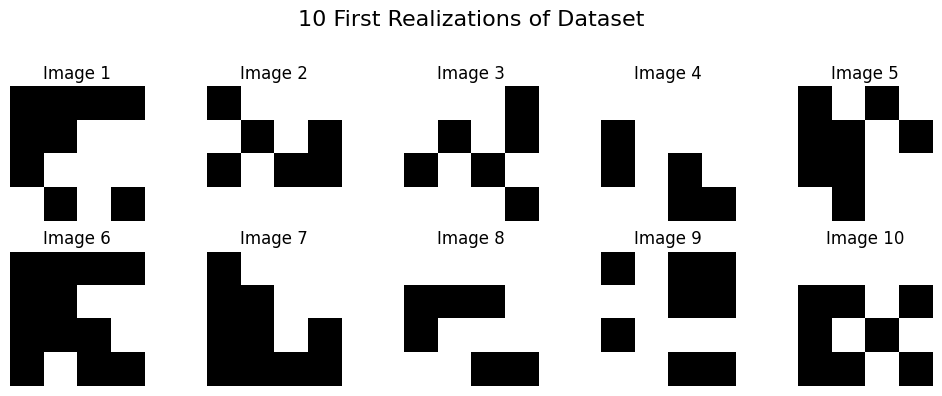

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: oscar-ovanger (oscars). Use `wandb login --relogin` to force relogin


In [3]:
import torch
import torch.nn as nn

class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout=0.0, hidden_dim=None):
        super().__init__()

        # Create the embedding matrix for 2-cell binary combinations + 1 mask token
        embedding_matrix = torch.zeros((num_tokens, embed_dim))  # Shape: (num_tokens, embed_dim)

        # Generate all possible 2-cell binary patches
        patches = torch.tensor([
            [a, b]
            for a in range(2)
            for b in range(2)
        ])  # Shape: (4, 2) for 4 combinations of 2-cell binary patches

        # Assign each patch's values as its embedding
        for i, patch in enumerate(patches):
            embedding_matrix[i, :] = patch  # Set the embedding to the patch values

        # Set the last row to all 2s for the masked token
        embedding_matrix[-1, :] = 0.5  # Mask token embedding

        # Create embedding layer
        self.embedding_matrix = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=True
        )

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

        # Load hidden_dim
        self.hidden_dim = hidden_dim

        # Linear layer to project input embeddings
        self.input_proj = nn.Linear(embed_dim, self.hidden_dim)

        # Positional embeddings
        self.positional_embedding = nn.Parameter(torch.randn(max_patches, 1, self.hidden_dim))  # Shape: (seq_len, 1, hidden_dim)

        # Output layer
        self.fc_out = nn.Linear(self.hidden_dim, num_tokens-1)

    def forward(self, patches):
        # Retrieve embeddings
        embeddings = self.embedding_matrix(patches)  # (batch_size, seq_len, embed_dim)

        # Prepare input for transformer layers
        x = embeddings.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim)

        # Extract seq_len and batch_size
        seq_len, batch_size, _ = x.size()

        # Project input to hidden_dim
        z = self.input_proj(x)  # Shape: (seq_len, batch_size, hidden_dim)

        # Add positional embedding
        pos_emb = self.positional_embedding[:seq_len, :, :].expand(-1, batch_size, -1)  # Shape: (seq_len, batch_size, hidden_dim)
        z = z + pos_emb

        # Pass through transformer layers
        for layer in self.encoder_layers:
            z = layer(z)

        # Output logits
        z = z.permute(1, 0, 2)  # Back to (batch_size, seq_len, hidden_dim)
        logits = self.fc_out(z)  # (batch_size, seq_len, num_tokens-1)
        return logits

    def get_probabilities(self, logits):
        """Compute probabilities using softmax."""
        return torch.softmax(logits, dim=-1)


class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, feedforward_dim, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Ensure hidden_dim is divisible by num_heads
        assert self.hidden_dim % self.num_heads == 0, "Hidden dimension must be divisible by the number of heads."

        # Multi-head attention
        self.attention = nn.MultiheadAttention(embed_dim=self.hidden_dim, num_heads=num_heads, dropout=dropout)

        # Feedforward network
        self.feedforward = nn.Sequential(
            nn.Linear(self.hidden_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, self.hidden_dim),
            nn.Dropout(dropout),
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(self.hidden_dim)
        self.norm2 = nn.LayerNorm(self.hidden_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, z):
        """
        Args:
            z: Tensor of shape (seq_len, batch_size, hidden_dim)
        Returns:
            Tensor of shape (seq_len, batch_size, hidden_dim)
        """
        seq_len, batch_size, hidden_dim = z.size()

        # Apply LayerNorm
        z_norm = self.norm1(z)

        # Self-attention
        attn_output, _ = self.attention(z_norm, z_norm, z_norm)  # Shape: (seq_len, batch_size, hidden_dim)

        # Residual connection
        z = z + self.dropout(attn_output)

        # Feedforward layer
        z_norm = self.norm2(z)
        feedforward_output = self.feedforward(z_norm)

        # Final residual connection
        z = z + self.dropout(feedforward_output)

        return z

import matplotlib.pyplot as plt
# Toy Dataset: 100 Binary 4x4 Images
images = torch.randint(0, 2, (100, 4, 4)).long()

# Plot the first 10 images in a 5x2 subplot
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle("10 First Realizations of Dataset", fontsize=16)

for idx, ax in enumerate(axs.flat):  # Flatten the 2D array of axes for easy iteration
    ax.imshow(images[idx].numpy(), cmap="gray")
    ax.set_title(f"Image {idx + 1}")
    ax.axis("off")  # Turn off the axes for cleaner visualization

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

import wandb
# Parameters
batch_size = 1
embed_dim = 2
hidden_dim = 3
num_heads = 1
feedforward_dim = hidden_dim*2  # (2-4)
num_layers = 1
num_tokens = 5  # 4 tokens + 1 mask token
max_patches = 8
dropout = 0.2
learning_rate = 3e-4
num_epochs = 100

# Initialize wandb
wandb.login()
wandb.init(
    project="vision-transformer-toy-example",
    config={
        "batch_size": batch_size,
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "feedforward_dim": feedforward_dim,
        "num_layers": num_layers,
        "num_tokens": num_tokens,
        "max_patches": max_patches,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
    },
)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout, hidden_dim).to(device)
#model.load_state_dict(checkpoint)  # Load model weights
# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#Dataloader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class BinaryImageDataset(Dataset):
    def __init__(self, images):
        """
        Args:
            images (Tensor): Tensor of shape (num_images, 64, 64) with binary values (0 or 1).
        """
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return torch.tensor(image, dtype=torch.float32)

dataset = BinaryImageDataset(images)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop

In [6]:
# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    current_mask_rate = 0.5

    for batch_idx, images in enumerate(dataloader):
        # Preprocess images
        patch_indices = torch.stack([preprocess_image(img) for img in images]).long()
        masked_patches = patch_indices.clone()

        # Masking
        mask = torch.rand(masked_patches.shape) < current_mask_rate
        masked_patches[mask] = num_tokens - 1

        # Calculate token weights dynamically
        token_counts = torch.bincount(patch_indices.view(-1), minlength=num_tokens)
        mask_token_count = mask.sum().item()
        token_counts[-1] = mask_token_count
        token_weights = 1.0 / (token_counts + 1e-6)
        token_weights = token_weights / token_weights.sum()
        token_weights = token_weights.to(device)

        # Define weighted CrossEntropyLoss
        criterion = nn.CrossEntropyLoss(weight=token_weights)

        # Move to device
        masked_patches, patch_indices, mask = (
            masked_patches.to(device),
            patch_indices.to(device),
            mask.to(device),
        )

        # Forward pass
        logits = model(masked_patches, mask)
        loss = criterion(logits.view(-1, num_tokens), patch_indices.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log batch metrics
        wandb.log({"batch_loss": loss.item()})

        # Visualization for the first batch in the epoch
        if batch_idx == 0:
            with torch.no_grad():
                predicted_indices = torch.argmax(logits, dim=-1).cpu()[0]
                reconstructed_image = reconstruct_image_from_patches(predicted_indices)

                visualized_masked_patches = masked_patches.cpu()[0].clone()
                visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
                masked_image = reconstruct_image_from_patches(visualized_masked_patches)

                # Log visualizations to wandb
                wandb.log({
                    "Original Image": wandb.Image(
                        reconstruct_image_from_patches(patch_indices.cpu()[0])
                    ),
                    "Masked Image": wandb.Image(masked_image, caption="Masked Image"),
                    "Reconstructed Image": wandb.Image(
                        reconstructed_image, caption="Reconstructed Image"
                    ),
                })

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

    # Log epoch metrics
    wandb.log({"epoch_loss": avg_loss})

# Save the final model
torch.save(model.state_dict(), "vision_transformer_final_balanced.pth")
wandb.save("vision_transformer_final_balanced.pth")
print("Final model saved as 'vision_transformer_final_balanced.pth'.")
wandb.finish()

idx:  0
batch:  tensor([[[1., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 1., 0., 1.],
         [0., 0., 1., 1.]]])


<ipython-input-3-b2b95076c0d1>:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32)
